### Foreword

This notebook is based on the provided example notebook from the CICIoT2023 dataset. Various improvements have been made such as actual random testing data, possibility to set random seeds, addition of undersampling+SMOTE preprocessing, more ML models and better performance metrics information.

# Introduction
The aim of the project was to find a information and communication technology related dataset to analyse using available machine learning tools. In that scope, a dataset related to malicious attacks on IoT devices were chosen. The aim is to study the feasibility of using ML as additional layer of security in network based attack detection.

The data was analysed using well-known ML and data analysis modules such as pandas, numpy, scikit-learn and pytorch. This report will describe the used dataset, as well as performance and characteristics regarding the used models and methods from the abovementioned modules.


# Dataset analysis
## Data gathering
The dataset analysis was performed in the preliminary report. The data contains several features of packets captured during a controlled attack with various methods on a setup IoT environment. The obtained packet capture files were transformed into .csv format describing flow features chosen by the people who obtained this data. The high level topology diagram is shown below:

![CICIoT2023 testbed diagram](images/cic-diagram3-2023.jpg)


## Feature description
The extracted features from the packet captures are:
- Ts – timestamp of the packet.
- Flow duration – packet travel time.
- Protocol type – defines transport or network layer protocol information.
- Duration – packet TTL.
- Rate, srate and drate – respectively: general rate of packet transmission in a flow, outbound rate, and inbound rate.
- FIN/SYN/RST/PSH/ACK/ECE/CWR flag number – (Boolean) values indicating status of TCP flags in the packet.
- ACK/SYN/FIN/URG/RST count – number of packets with these flags set in the same flow. These flags are important in the context of TCP and TCP-related attacks.
- HTTP/HTTPS/DNS/Telnet/SMTP/SSH/IRC/DHCP – (Boolean) values indicating presence of application layer protocols.
- TCP/UDP – (Boolean) values indicating presence of transport layer protocols.
- ICMP/IPv – like above but for network layer.
- ARP/LLC – like above but for link layer.
- Tot sum, min, max, avg, std – respectively the sum, minimum, maximum, average, standard deviation of packet lengths in a flow.
- Tot size – length of a single packet.
- IAT – time delta with the previous packet.
- Number – count of packets in a flow.

For the below values, where:
- $l_i$: length of ingress packets in flow.
- $l_o$: length of egress packets in flow.

1. **Magnitude:**
   - $\text{Magnitude} = \sqrt{\overline{l_i} + \overline{l_o}}$

2. **Radius:**
   - $\text{Radius} = \sqrt{{\text{Var}(l_i)}^2 + {\text{Var}(l_o)}^2}$
   - (where $\text{Var}(x)$ represents the variance of $x$)

3. **Covariance:**
   - $\text{Covariance} = \text{Cov}(l_i,l_o)$

4. **Variance:**
   - $\text{Variance} = \frac{{l_i}^2}{{l_o}^2}$

5. **Weight:**
   - $\text{Weight} = \text{count\_ingress} \times \text{count\_egress}$

Since there are a lot of features, feature selection could be a good idea to remove unimportant features. This is described in detail later.

Below is shown the definition of X_column labels in Python


In [46]:
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
       'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count',
       'syn_count', 'fin_count', 'urg_count', 'rst_count', 
    'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
       'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
       'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
       'Radius', 'Covariance', 'Variance', 'Weight', 
]
y_column = 'label'

## Label description
The labels are different attack types that the packet metrics correspond to. This is the full list of labels:
- DDoS – Distributed Denial of Service
  - ICMP Flood
  - ICMP Fragmentation
  - UDP Flood
  - UDP Fragmentation
  - TCP Flood
  - PSHACK Flood
  - ACK Fragmentation
  - SYN Flood
  - RSTFIN Flood
  - SynonymousIP Flood
  - HTTP Flood
  - Slow Loris
- DoS – Denial of Service
  - UDP Flood
  - TCP Flood
  - SYN Flood
  - HTTP Flood
- Benign traffic
- Mirai – IoT Botnet
  - GRE Flood
  - UDP Plain
  - GREIP Flood
- Spoofing
  - ARP
  - DNS
- Recon – Reconnaissance
  - OS Scan
  - Port Scan
  - Vulnerability Scan
  - Ping Sweep
- Dictionary Bruteforce
- Web
  - Browser Hijacking
  - Command Injection
  - SQL Injection
  - XSS
  - Backdoor Malware
  - Uploading Attack

There are in total 34 labels that can be reduced to 8 labels based on the main type or even down to 2 classes to do a binary classification whether the packet is malicious or benign. For the 8 or 2 label scenario, a different neural network or system could be trained to determine the exact attack type. However, in case of security the binary classification can be sufficient to prevent malicious traffic.


## Class distribution and imbalance reduction
The class distribution of the whole dataset is shown below:

![Class distribution](images/inline-bar-graphjpg.jpg)

As it can be seen, the dataset is significantly imbalanced towards the DDoS and DoS packets. This can be an issue for some of the machine learning algorithms. Despite the nature of DDoS and DoS being flooding, thus causing the imbalance, it was chosen to apply SMOTE + under-sampling technique for the sampling data. 

First, under-sampling will remove excessive DDoS and DoS data. The counts will match the benign packet counts. Then, SMOTE will create artificial samples for the minority classes to match the earlier under-sampled counts. That way the label counts will be balanced. This mechanism is implemented in the main loop mechanism and the logic to realise it is explained in inline comments.

For dataset parts that do not have enough samples (6) in the minority classes to apply SMOTE, random oversampling will be first applied to these classes to make them valid for SMOTE. Skipping these datasets would cause different dataset parts to be used in non-preprocessing notebook despite seed being the same. This would cause incorrect comparison.

In [44]:
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm
import warnings
import random
SEED = 42  # Set to None for randomness
if SEED:
    random.seed(SEED)
    print(f"INFO: Using seed {SEED}")
else:
    print(f"Using random seed")

# Manual train/test splitting
warnings.filterwarnings('ignore')

INFO: Using seed 42


In [45]:
DATASET_DIRECTORY = '../CICIoT2023/'

### Importing Dataset

In [47]:
from collections import Counter
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()

bad_indexes = [1, 2, 3, 11, 12, 13, 15, 16, 17, 22, 28, 29, 31, 32, 40, 42, 43, 49, 50, 59, 60, 61, 65, 68, 70, 80, 83, 84, 88, 92, 100, 102, 103, 104, 108, 110, 112, 115, 117, 119, 121, 128, 129, 132, 134, 139, 141, 146, 147, 148, 150, 154, 158, 160, 163]
if len(bad_indexes) == 0:
    for i, d_set in enumerate(tqdm(df_sets)):
        d = pd.read_csv(DATASET_DIRECTORY + d_set)
        label_counts = Counter(d[y_column]).most_common()
        lowest_label_count = int(label_counts[-1][1])
        if lowest_label_count <= 5:  # 5 is the n_neighbors of SMOTE
            print(f"Dataset at index {i} not suitable for SMOTE. Lowest label has only {lowest_label_count} samples")
            bad_indexes.append(i)
    # Around 20 % of dataset parts are not suitable for SMOTE with k_neighbors = 5
    
test_indexes_count = int(len(df_sets)*0.2)//4
train_indexes_count = int(len(df_sets)*0.8)//4
index_range = range(len(df_sets))
test_indexes = random.sample(index_range, test_indexes_count)
train_indexes = [i for i in index_range if i not in test_indexes and i not in bad_indexes][:train_indexes_count]
training_sets, test_sets = [], []
for i in train_indexes:
    training_sets.append(df_sets[i])
for i in test_indexes:
    test_sets.append(df_sets[i])
# training_sets = df_sets[:int(len(df_sets)*.8)]
# test_sets = df_sets[int(len(df_sets)*.8):]
print("Do not use these indexes for training:")
print(bad_indexes)

Do not use these indexes for training:
[1, 2, 3, 11, 12, 13, 15, 16, 17, 22, 28, 29, 31, 32, 40, 42, 43, 49, 50, 59, 60, 61, 65, 68, 70, 80, 83, 84, 88, 92, 100, 102, 103, 104, 108, 110, 112, 115, 117, 119, 121, 128, 129, 132, 134, 139, 141, 146, 147, 148, 150, 154, 158, 160, 163]


### Scaling

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [49]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


### Classification: 34 (33+1) classes

In [50]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import f1_score
from collections import Counter

ML_models = [ # or 'rbf', 'poly' for different kernels
        LogisticRegression(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        xgb.XGBClassifier(
            eval_metric=f1_score,
            random_state=SEED,
            device='cuda'
        )
        
]
ML_neams = [
        'LogisticRegresion',
        'Decision Tree',
        'Random Forest',
        'eXtreme Gradient Boosting'
]

label_encoder = LabelEncoder()
for train_set in tqdm(training_sets):
    d = pd.read_csv(DATASET_DIRECTORY + train_set)
    # Undersample until there are no classes which have more samples than benign, and then apply SMOTE
    label_counts = Counter(d[y_column]).most_common()
    old_len = len(d[y_column])
    benign_index = next((i for i, l in enumerate(label_counts) if l[0] == 'BenignTraffic'))
    print({l[0]: label_counts[benign_index][1] for l in label_counts[:benign_index]})
    resampling_pipeline = Pipeline([
        ('under', RandomUnderSampler(sampling_strategy={l[0]: label_counts[benign_index][1] for l in label_counts[:benign_index]}, random_state=42)),
        ('SMOTE', SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5))
    ])
    X, y = resampling_pipeline.fit_resample(d[X_columns], d[y_column])
    new_len = len(y)
    print(f"Old: {old_len}; New: {new_len}")
    del d
    X = scaler.fit_transform(X)
    for i, model in enumerate(ML_models):
        if i == len(ML_models)-1:
            y = label_encoder.fit_transform(y)
        model.fit(X, y)

  0%|          | 0/33 [00:00<?, ?it/s]

{'DDoS-ICMP_Flood': 5600, 'DDoS-UDP_Flood': 5600, 'DDoS-TCP_Flood': 5600, 'DDoS-PSHACK_Flood': 5600, 'DDoS-SYN_Flood': 5600, 'DDoS-RSTFINFlood': 5600, 'DDoS-SynonymousIP_Flood': 5600, 'DoS-UDP_Flood': 5600, 'DoS-TCP_Flood': 5600, 'DoS-SYN_Flood': 5600}
Old: 238687; New: 190400
{'DDoS-ICMP_Flood': 5386, 'DDoS-UDP_Flood': 5386, 'DDoS-TCP_Flood': 5386, 'DDoS-SYN_Flood': 5386, 'DDoS-PSHACK_Flood': 5386, 'DDoS-RSTFINFlood': 5386, 'DDoS-SynonymousIP_Flood': 5386, 'DoS-UDP_Flood': 5386, 'DoS-TCP_Flood': 5386, 'DoS-SYN_Flood': 5386}
Old: 227491; New: 183124
{'DDoS-ICMP_Flood': 5787, 'DDoS-UDP_Flood': 5787, 'DDoS-TCP_Flood': 5787, 'DDoS-PSHACK_Flood': 5787, 'DDoS-SYN_Flood': 5787, 'DDoS-RSTFINFlood': 5787, 'DDoS-SynonymousIP_Flood': 5787, 'DoS-UDP_Flood': 5787, 'DoS-TCP_Flood': 5787, 'DoS-SYN_Flood': 5787}
Old: 240046; New: 196758
{'DDoS-ICMP_Flood': 5327, 'DDoS-UDP_Flood': 5327, 'DDoS-TCP_Flood': 5327, 'DDoS-PSHACK_Flood': 5327, 'DDoS-RSTFINFlood': 5327, 'DDoS-SYN_Flood': 5327, 'DDoS-Synonymou

In [51]:
y_test = []
preds = {i:[] for i in range(len(ML_models))}
for test_set in tqdm(test_sets):
    d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    d_test[X_columns] = scaler.transform(d_test[X_columns])
    
    y_test += list(d_test[y_column].values)
    
    for i in range(len(ML_models)):
        model = ML_models[i]
        y_pred = list(model.predict(d_test[X_columns]))
        if i == len(ML_models)-1:
            y_pred = list(label_encoder.inverse_transform(model.predict(d_test[X_columns])))
        preds[i] = preds[i] + y_pred
        

  0%|          | 0/8 [00:00<?, ?it/s]

In [52]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print("### 34 CLASSES; PREPROCESSED ###")
print("Model;accuracy;recall;precision;f1")
for k,v in preds.items():
    y_pred = v
    print(f"MACRO;{ML_neams[k]};{accuracy_score(y_pred, y_test)};{recall_score(y_pred, y_test, average='macro')};{precision_score(y_pred, y_test, average='macro')};{f1_score(y_pred, y_test, average='macro')}")
    print(f"WEIGHTED;{ML_neams[k]};{accuracy_score(y_pred, y_test)};{recall_score(y_pred, y_test, average='weighted')};{precision_score(y_pred, y_test, average='weighted')};{f1_score(y_pred, y_test, average='weighted')}")
    cm = confusion_matrix(y_test, y_pred)
    cn = ML_models[k].classes_
    if ML_neams[k] == ML_neams[-1]:
        cn = label_encoder.inverse_transform(ML_models[k].classes_)
    
    # plt.figure(figsize=(12, 9))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cn, yticklabels=cn)
    # plt.xlabel('Predicted')
    # plt.ylabel('Actual')
    # plt.title('Confusion Matrix')
    # plt.savefig('confusion_matrix_seaborn.png', dpi=500, bbox_inches='tight')
    # plt.show()
    
    # Convert confusion matrix array to a DataFrame
    cm_df = pd.DataFrame(cm, index=cn, columns=cn)
    
    # Export the DataFrame to a CSV file
    cm_df.to_csv(f'cms-42-preprocessing/confusion_matrix-{ML_neams[k]}-34.csv')

print('\n\n')

### 34 CLASSES; PREPROCESSED ###
Model;accuracy;recall;precision;f1
MACRO;LogisticRegresion;0.7887857691596086;0.5016442070051597;0.5552984870641594;0.49307693991810286
WEIGHTED;LogisticRegresion;0.7887857691596086;0.7887857691596086;0.8291256334799271;0.7983541206097434
MACRO;Decision Tree;0.9900159843042712;0.7672134598518945;0.8283009415844466;0.7882874273342091
WEIGHTED;Decision Tree;0.9900159843042712;0.9900159843042712;0.9894519172890185;0.9896175416654341
MACRO;Random Forest;0.9897759380975428;0.7472781935017468;0.7568776631506969;0.7476715469456955
WEIGHTED;Random Forest;0.9897759380975428;0.9897759380975428;0.9900452324685083;0.9897823704292169
MACRO;eXtreme Gradient Boosting;0.9931946467096121;0.8126340755385238;0.8034241155588516;0.8069787620452056
WEIGHTED;eXtreme Gradient Boosting;0.9931946467096121;0.9931946467096121;0.9933508886772571;0.9932579331719085


# Classification: 8 (7+1) classes

In [53]:
if True:
    dict_7classes = {}
    dict_7classes['DDoS-RSTFINFlood'] = 'DDoS'
    dict_7classes['DDoS-PSHACK_Flood'] = 'DDoS'
    dict_7classes['DDoS-SYN_Flood'] = 'DDoS'
    dict_7classes['DDoS-UDP_Flood'] = 'DDoS'
    dict_7classes['DDoS-TCP_Flood'] = 'DDoS'
    dict_7classes['DDoS-ICMP_Flood'] = 'DDoS'
    dict_7classes['DDoS-SynonymousIP_Flood'] = 'DDoS'
    dict_7classes['DDoS-ACK_Fragmentation'] = 'DDoS'
    dict_7classes['DDoS-UDP_Fragmentation'] = 'DDoS'
    dict_7classes['DDoS-ICMP_Fragmentation'] = 'DDoS'
    dict_7classes['DDoS-SlowLoris'] = 'DDoS'
    dict_7classes['DDoS-HTTP_Flood'] = 'DDoS'
    
    dict_7classes['DoS-UDP_Flood'] = 'DoS'
    dict_7classes['DoS-SYN_Flood'] = 'DoS'
    dict_7classes['DoS-TCP_Flood'] = 'DoS'
    dict_7classes['DoS-HTTP_Flood'] = 'DoS'
    
    
    dict_7classes['Mirai-greeth_flood'] = 'Mirai'
    dict_7classes['Mirai-greip_flood'] = 'Mirai'
    dict_7classes['Mirai-udpplain'] = 'Mirai'
    
    dict_7classes['Recon-PingSweep'] = 'Recon'
    dict_7classes['Recon-OSScan'] = 'Recon'
    dict_7classes['Recon-PortScan'] = 'Recon'
    dict_7classes['VulnerabilityScan'] = 'Recon'
    dict_7classes['Recon-HostDiscovery'] = 'Recon'
    
    dict_7classes['DNS_Spoofing'] = 'Spoofing'
    dict_7classes['MITM-ArpSpoofing'] = 'Spoofing'
    
    dict_7classes['BenignTraffic'] = 'Benign'
    
    dict_7classes['BrowserHijacking'] = 'Web'
    dict_7classes['Backdoor_Malware'] = 'Web'
    dict_7classes['XSS'] = 'Web'
    dict_7classes['Uploading_Attack'] = 'Web'
    dict_7classes['SqlInjection'] = 'Web'
    dict_7classes['CommandInjection'] = 'Web'
    
    
    dict_7classes['DictionaryBruteForce'] = 'BruteForce'

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

ML_models = [ # or 'rbf', 'poly' for different kernels
        LogisticRegression(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        xgb.XGBClassifier(
            n_estimators=100,
            max_depth=10,
            learning_rate=0.1,
            random_state=SEED,
            device='cuda'
        ),
        
]

ML_neams = [
        'LogisticRegresion',
        'Decision Tree',
        'Random Forest',
        'eXtreme Gradient Boosting'
]
for train_set in tqdm(training_sets):
    d = pd.read_csv(DATASET_DIRECTORY + train_set)
    # Undersample until there are no classes which have more samples than benign, and then apply SMOTE
    label_counts = Counter(d[y_column]).most_common()
    old_len = len(d[y_column])
    benign_index = next((i for i, l in enumerate(label_counts) if l[0] == 'BenignTraffic'))
    resampling_pipeline = Pipeline([
        ('under', RandomUnderSampler(sampling_strategy={l[0]: benign_index for l in label_counts[:benign_index]}, random_state=42)),
        ('SMOTE', SMOTE(sampling_strategy='auto', random_state=42))
    ])
    X, y = resampling_pipeline.fit_resample(d[X_columns], d[y_column])
    new_len = len(y)
    print(f"Old: {old_len}; New: {new_len}")
    del d
    
    new_y = [dict_7classes[k] for k in y]
    y = new_y
    X = scaler.fit_transform(X)
    for i, model in enumerate(ML_models):
        if i == len(ML_models)-1:
            y = label_encoder.fit_transform(y)
        model.fit(X, y)
    


  0%|          | 0/33 [00:00<?, ?it/s]

Old: 238687; New: 190400
Old: 227491; New: 183124
Old: 240046; New: 196758
Old: 227910; New: 181118
Old: 246327; New: 199716
Old: 227616; New: 185776
Old: 251392; New: 203728
Old: 215838; New: 171564
Old: 234430; New: 187578
Old: 231063; New: 183498
Old: 237151; New: 186592
Old: 223401; New: 177242
Old: 262062; New: 214608
Old: 225725; New: 174862
Old: 447625; New: 357850
Old: 221014; New: 179894
Old: 238350; New: 195058
Old: 447774; New: 357170
Old: 232228; New: 184960
Old: 439212; New: 353804
Old: 214963; New: 176324
Old: 236660; New: 189006
Old: 437362; New: 347718
Old: 445281; New: 351594
Old: 231980; New: 186524
Old: 247290; New: 200056
Old: 235566; New: 188700
Old: 239086; New: 190672
Old: 219877; New: 176324
Old: 251256; New: 199682
Old: 445425; New: 355538
Old: 243279; New: 190706
Old: 235625; New: 186864


In [55]:
y_test = []
preds = {i:[] for i in range(len(ML_models))}
for test_set in tqdm(test_sets):
    d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    d_test[X_columns] = scaler.transform(d_test[X_columns])
    new_y = [dict_7classes[k] for k in d_test[y_column]]
    d_test[y_column] = new_y
    
    y_test += list(d_test[y_column].values)
    
    for i in range(len(ML_models)):
        model = ML_models[i]
        y_pred = list(model.predict(d_test[X_columns]))
        if i == len(ML_models)-1:
            y_pred = list(label_encoder.inverse_transform(model.predict(d_test[X_columns])))
        preds[i] = preds[i] + y_pred
        

  0%|          | 0/8 [00:00<?, ?it/s]

### 8 CLASSES; PREPROCESSED ###
Model;accuracy;recall;precision;f1
MACRO;LogisticRegresion;0.7582024092146546;0.5214787605411961;0.5521956120262423;0.47859116055550643
WEIGHTED;LogisticRegresion;0.7582024092146546;0.7582024092146546;0.7758126440914819;0.7614228547507761


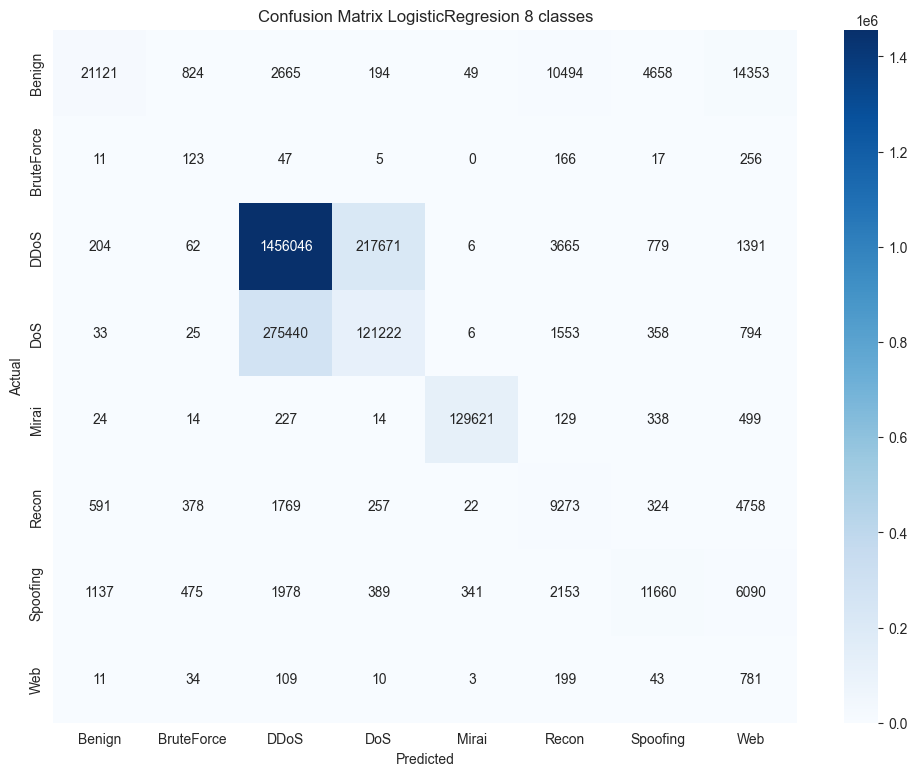

MACRO;Decision Tree;0.9886640995299167;0.745385377215712;0.818345758084842;0.7728340887275655
WEIGHTED;Decision Tree;0.9886640995299167;0.9886640995299167;0.9882752162295545;0.9883148169689258


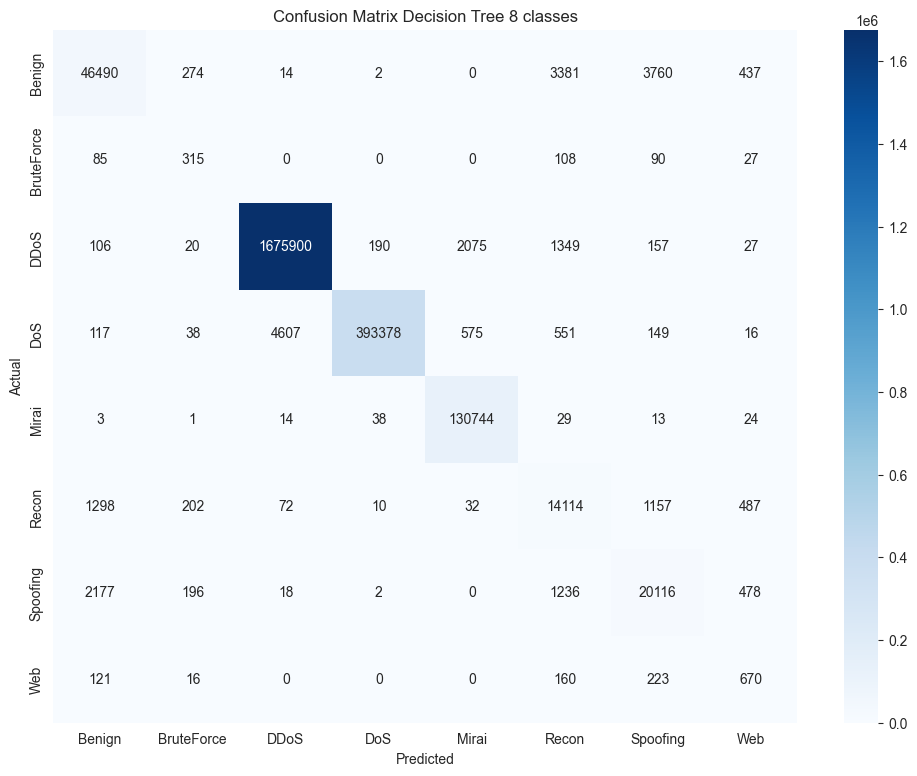

MACRO;Random Forest;0.9909683697959477;0.7838359449388974;0.7680217562326519;0.7643176859134178
WEIGHTED;Random Forest;0.9909683697959477;0.9909683697959477;0.9908563999782185;0.990790174689826


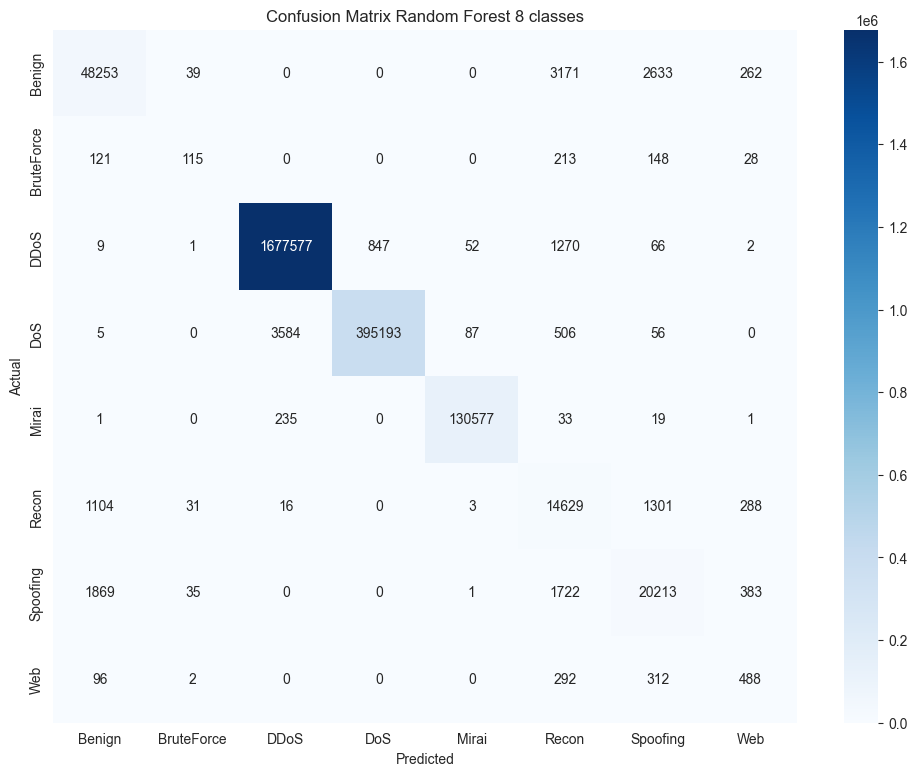

MACRO;eXtreme Gradient Boosting;0.9907144581043542;0.8030291828990053;0.8347706693310036;0.8114363960142286
WEIGHTED;eXtreme Gradient Boosting;0.9907144581043542;0.9907144581043542;0.9905304311308732;0.990500296883589


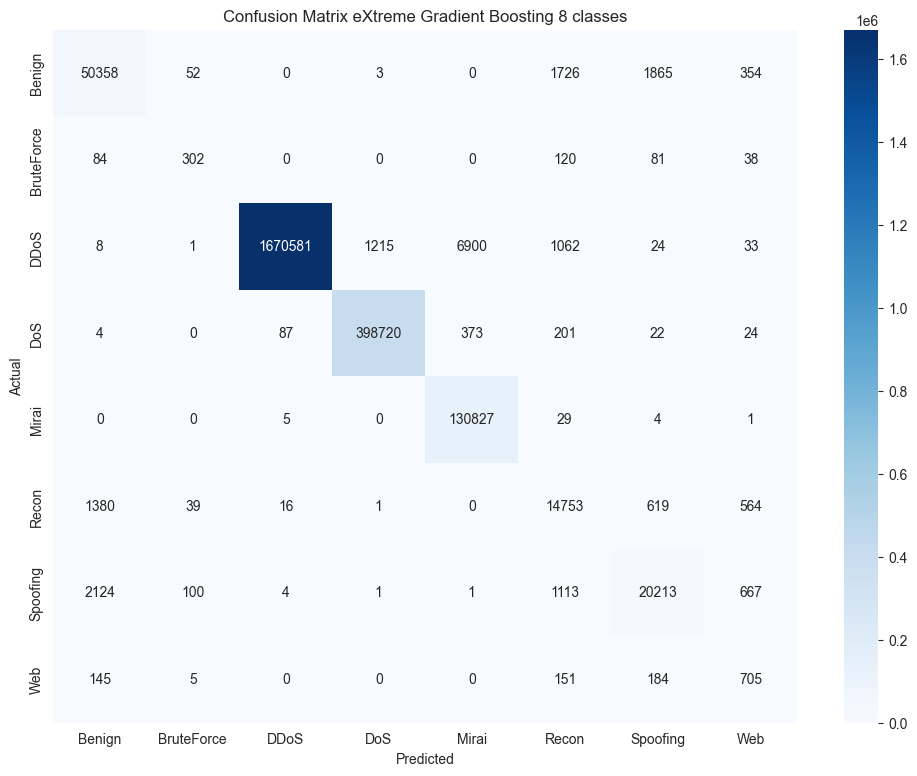

In [56]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
print("### 8 CLASSES; PREPROCESSED ###")
print("Model;accuracy;recall;precision;f1")
for k,v in preds.items():
    y_pred = v
    print(f"MACRO;{ML_neams[k]};{accuracy_score(y_pred, y_test)};{recall_score(y_pred, y_test, average='macro')};{precision_score(y_pred, y_test, average='macro')};{f1_score(y_pred, y_test, average='macro')}")
    print(f"WEIGHTED;{ML_neams[k]};{accuracy_score(y_pred, y_test)};{recall_score(y_pred, y_test, average='weighted')};{precision_score(y_pred, y_test, average='weighted')};{f1_score(y_pred, y_test, average='weighted')}")
    
    cm = confusion_matrix(y_test, y_pred)
    cn = ML_models[k].classes_
    if ML_neams[k] == ML_neams[-1]:
        cn = label_encoder.inverse_transform(ML_models[k].classes_)
    
    plt.figure(figsize=(12, 9))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cn, yticklabels=cn)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix {ML_neams[k]} 8 classes')
    plt.show()
    
    # Convert confusion matrix array to a DataFrame
    cm_df = pd.DataFrame(cm, index=cn, columns=cn)
    
    # Export the DataFrame to a CSV file
    cm_df.to_csv(f'cms-42-preprocessing/confusion_matrix-{ML_neams[k]}-8.csv')

print('\n\n')

# Classification: 2 (1+1) Classes

In [57]:
if True:
    dict_2classes = {}
    dict_2classes['DDoS-RSTFINFlood'] = 'Attack'
    dict_2classes['DDoS-PSHACK_Flood'] = 'Attack'
    dict_2classes['DDoS-SYN_Flood'] = 'Attack'
    dict_2classes['DDoS-UDP_Flood'] = 'Attack'
    dict_2classes['DDoS-TCP_Flood'] = 'Attack'
    dict_2classes['DDoS-ICMP_Flood'] = 'Attack'
    dict_2classes['DDoS-SynonymousIP_Flood'] = 'Attack'
    dict_2classes['DDoS-ACK_Fragmentation'] = 'Attack'
    dict_2classes['DDoS-UDP_Fragmentation'] = 'Attack'
    dict_2classes['DDoS-ICMP_Fragmentation'] = 'Attack'
    dict_2classes['DDoS-SlowLoris'] = 'Attack'
    dict_2classes['DDoS-HTTP_Flood'] = 'Attack'
    
    dict_2classes['DoS-UDP_Flood'] = 'Attack'
    dict_2classes['DoS-SYN_Flood'] = 'Attack'
    dict_2classes['DoS-TCP_Flood'] = 'Attack'
    dict_2classes['DoS-HTTP_Flood'] = 'Attack'
    
    
    dict_2classes['Mirai-greeth_flood'] = 'Attack'
    dict_2classes['Mirai-greip_flood'] = 'Attack'
    dict_2classes['Mirai-udpplain'] = 'Attack'
    
    dict_2classes['Recon-PingSweep'] = 'Attack'
    dict_2classes['Recon-OSScan'] = 'Attack'
    dict_2classes['Recon-PortScan'] = 'Attack'
    dict_2classes['VulnerabilityScan'] = 'Attack'
    dict_2classes['Recon-HostDiscovery'] = 'Attack'
    
    dict_2classes['DNS_Spoofing'] = 'Attack'
    dict_2classes['MITM-ArpSpoofing'] = 'Attack'
    
    dict_2classes['BenignTraffic'] = 'Benign'
    
    dict_2classes['BrowserHijacking'] = 'Attack'
    dict_2classes['Backdoor_Malware'] = 'Attack'
    dict_2classes['XSS'] = 'Attack'
    dict_2classes['Uploading_Attack'] = 'Attack'
    dict_2classes['SqlInjection'] = 'Attack'
    dict_2classes['CommandInjection'] = 'Attack'
    
    dict_2classes['DictionaryBruteForce'] = 'Attack'

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
ML_models = [ # or 'rbf', 'poly' for different kernels
        LogisticRegression(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        xgb.XGBClassifier(
            n_estimators=100,
            max_depth=10,
            learning_rate=0.1,
            random_state=SEED,
            device='cuda'
        ),
        
]

ML_neams = [
        'LogisticRegresion',
        'Decision Tree',
        'Random Forest',
        'eXtreme Gradient Boosting'
]
for train_set in tqdm(training_sets):
    d = pd.read_csv(DATASET_DIRECTORY + train_set)
    # Undersample until there are no classes which have more samples than benign, and then apply SMOTE
    label_counts = Counter(d[y_column]).most_common()
    old_len = len(d[y_column])
    benign_index = next((i for i, l in enumerate(label_counts) if l[0] == 'BenignTraffic'))
    resampling_pipeline = Pipeline([
        ('under', RandomUnderSampler(sampling_strategy={l[0]: benign_index for l in label_counts[:benign_index]}, random_state=42)),
        ('SMOTE', SMOTE(sampling_strategy='auto', random_state=42))
    ])
    X, y = resampling_pipeline.fit_resample(d[X_columns], d[y_column])
    new_len = len(y)
    print(f"Old: {old_len}; New: {new_len}")
    new_y = [dict_2classes[k] for k in y]
    y = new_y
    del d
    X = scaler.fit_transform(X)
    for i, model in enumerate(ML_models):
        if i == len(ML_models)-1:
            y = label_encoder.fit_transform(y)
        model.fit(X, y)

  0%|          | 0/33 [00:00<?, ?it/s]

Old: 238687; New: 190400
Old: 227491; New: 183124
Old: 240046; New: 196758
Old: 227910; New: 181118
Old: 246327; New: 199716
Old: 227616; New: 185776
Old: 251392; New: 203728
Old: 215838; New: 171564
Old: 234430; New: 187578
Old: 231063; New: 183498
Old: 237151; New: 186592
Old: 223401; New: 177242
Old: 262062; New: 214608
Old: 225725; New: 174862
Old: 447625; New: 357850
Old: 221014; New: 179894
Old: 238350; New: 195058
Old: 447774; New: 357170
Old: 232228; New: 184960
Old: 439212; New: 353804
Old: 214963; New: 176324
Old: 236660; New: 189006
Old: 437362; New: 347718
Old: 445281; New: 351594
Old: 231980; New: 186524
Old: 247290; New: 200056
Old: 235566; New: 188700
Old: 239086; New: 190672
Old: 219877; New: 176324
Old: 251256; New: 199682
Old: 445425; New: 355538
Old: 243279; New: 190706
Old: 235625; New: 186864


In [59]:
y_test = []
preds = {i:[] for i in range(len(ML_models))}
for test_set in tqdm(test_sets):
    d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    d_test[X_columns] = scaler.transform(d_test[X_columns])
    new_y = [dict_2classes[k] for k in d_test[y_column]]
    d_test[y_column] = new_y
    
    y_test += list(d_test[y_column].values)
    
    for i in range(len(ML_models)):
        model = ML_models[i]
        y_pred = list(model.predict(d_test[X_columns]))
        if i == len(ML_models)-1:
            y_pred = list(label_encoder.inverse_transform(model.predict(d_test[X_columns])))
        preds[i] = preds[i] + y_pred
        

  0%|          | 0/8 [00:00<?, ?it/s]

### 2 CLASSES; PREPROCESSED ###
Model;accuracy;recall;precision;f1
MACRO;LogisticRegresion;0.9826828759962026;0.9500241327975405;0.6452627579791852;0.7165882438211172
WEIGHTED;LogisticRegresion;0.9826828759962026;0.9826828759962026;0.9940661884486193;0.9870969453568954


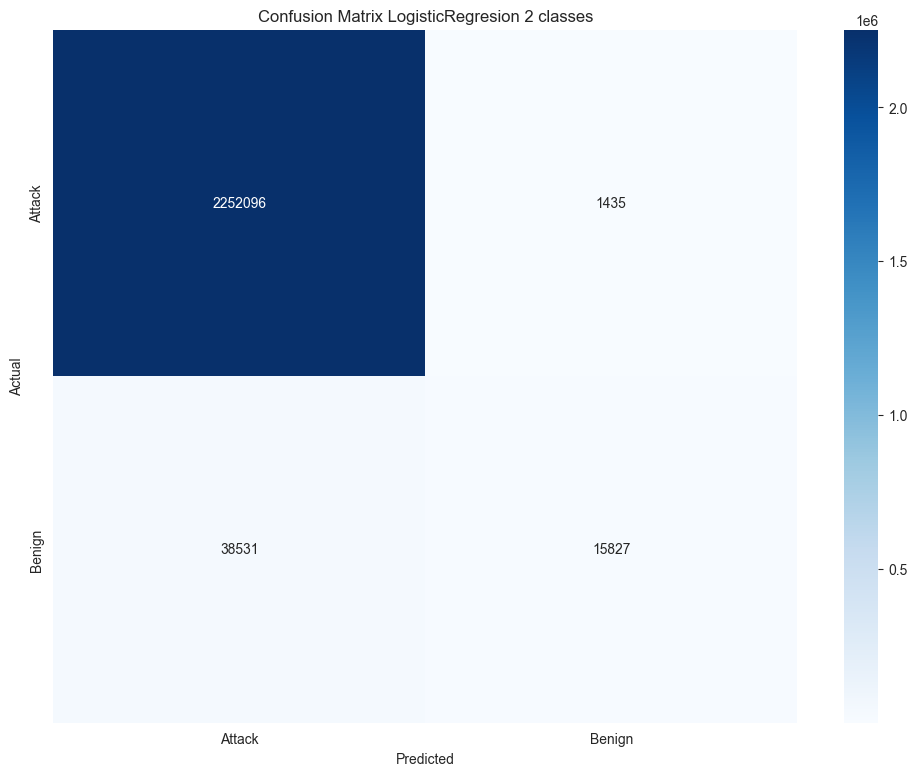

MACRO;Decision Tree;0.994789177469107;0.953528400251193;0.9308973765334754;0.9419081501125945
WEIGHTED;Decision Tree;0.994789177469107;0.994789177469107;0.9949504777755379;0.9948558446498372


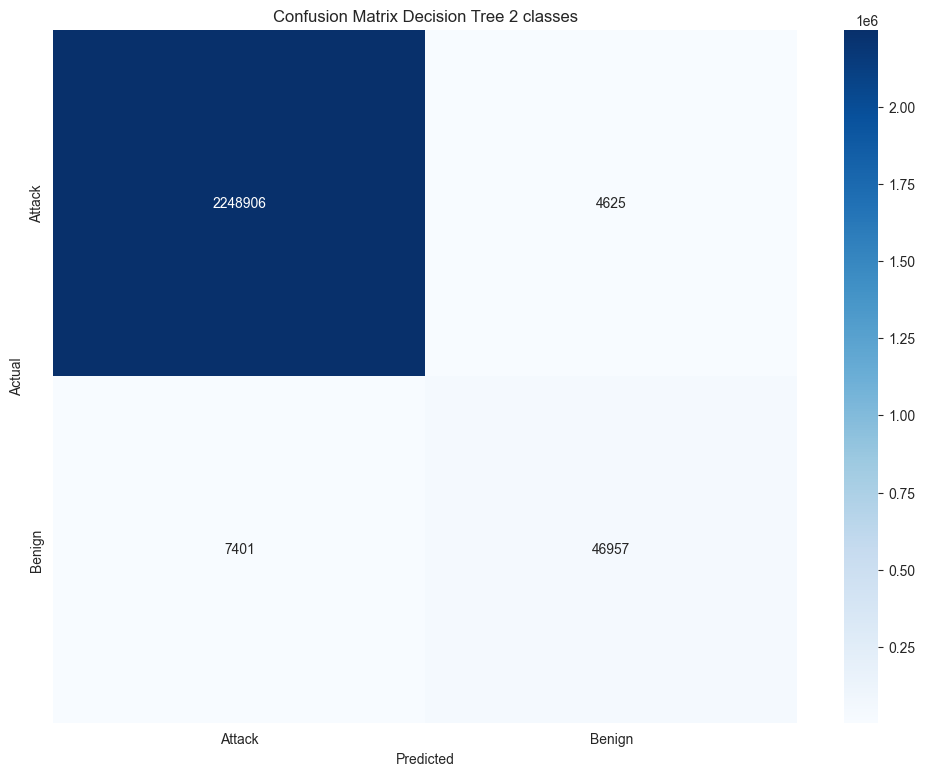

MACRO;Random Forest;0.9956193733754093;0.9769697734597;0.9254519189193631;0.949666552885241
WEIGHTED;Random Forest;0.9956193733754093;0.9956193733754093;0.9960022488715492;0.9957444052540606


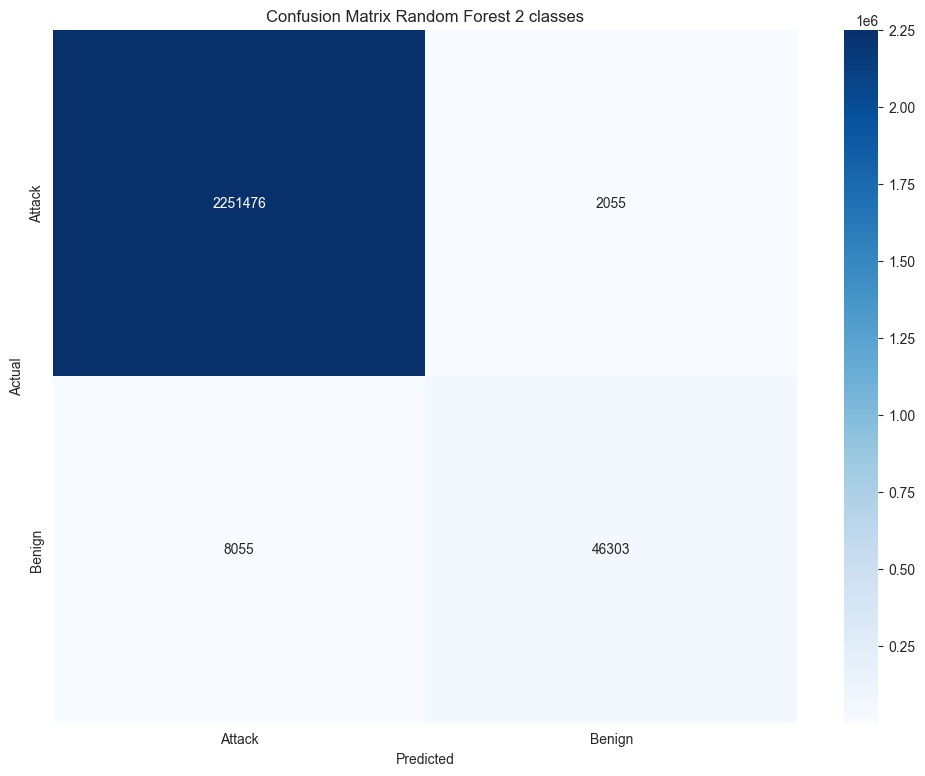

MACRO;eXtreme Gradient Boosting;0.9964954987003274;0.9693126241410973;0.9534760614590106;0.961251414438838
WEIGHTED;eXtreme Gradient Boosting;0.9964954987003274;0.9964954987003274;0.9965689722316406;0.9965255699663922


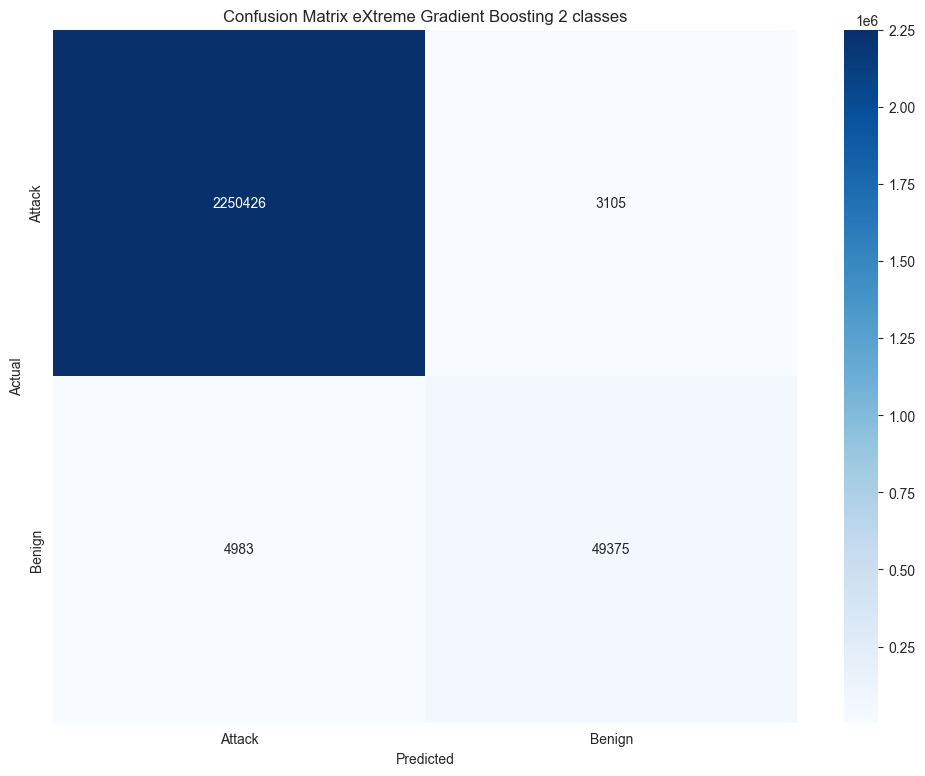

In [60]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
print("### 2 CLASSES; PREPROCESSED ###")
print("Model;accuracy;recall;precision;f1")
for k,v in preds.items():
    y_pred = v
    print(f"MACRO;{ML_neams[k]};{accuracy_score(y_pred, y_test)};{recall_score(y_pred, y_test, average='macro')};{precision_score(y_pred, y_test, average='macro')};{f1_score(y_pred, y_test, average='macro')}")
    print(f"WEIGHTED;{ML_neams[k]};{accuracy_score(y_pred, y_test)};{recall_score(y_pred, y_test, average='weighted')};{precision_score(y_pred, y_test, average='weighted')};{f1_score(y_pred, y_test, average='weighted')}")
    
    cm = confusion_matrix(y_test, y_pred)
    cn = ML_models[k].classes_
    if ML_neams[k] == ML_neams[-1]:
        cn = label_encoder.inverse_transform(ML_models[k].classes_)
    
    plt.figure(figsize=(12, 9))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cn, yticklabels=cn)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix {ML_neams[k]} 2 classes')
    plt.show()
    
    # Convert confusion matrix array to a DataFrame
    cm_df = pd.DataFrame(cm, index=cn, columns=cn)
    
    # Export the DataFrame to a CSV file
    cm_df.to_csv(f'cms-42-preprocessing/confusion_matrix-{ML_neams[k]}-2.csv')

print('\n\n')